In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

from keras import layers, optimizers, models
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import Image, SVG
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from tensorflow.keras.regularizers import l1, l2, l1_l2


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
pd.options.mode.chained_assignment = None

from sklearn.svm import SVR
# from skrvm import RVR
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from keras.utils import to_categorical
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.models import Model
from tensorflow.keras.optimizers import Adam,Adagrad
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
import keras
import talos

In [3]:
#評估指標
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
train_data = pandas.read_csv("adult.data", encoding="UTF-8", header=None)
test_data = pandas.read_csv("adult.test", encoding="UTF-8", header=None, skiprows=1) # skip 第一行

test_data[14] = test_data[14].str.replace('.', '') # 將 test_data class label 最後多餘的點去掉
train_data = train_data.replace(' ?', np.nan) # 將 missing value 改成 NaN
test_data = test_data.replace(' ?', np.nan) # 將 missing value 改成 NaN

# 
# if instances with unknown values are removed (train=30162, test=15060)
# 
train_data = train_data.dropna() # 去掉 missing value 的那筆資料，剩下 30162 筆
test_data = test_data.dropna() # 去掉 missing value 的那筆資料，剩下 15060 筆

cols = train_data.columns.tolist() # 把train_data的columns轉換成list
cols.insert(14, cols.pop(cols.index(3))) # 調換 12 跟 14 列

cols = test_data.columns.tolist() # 把test_data的columns轉換成list
cols.insert(14,cols.pop(cols.index(3))) # 調換 12 跟 14 列
# cols

train_data = train_data.loc[:,cols] # set剛剛重新定位的columns
# train_data
test_data = test_data.loc[:,cols] # set剛剛重新定義的columns
# test_data
train_data.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] # 對train_data的cloumns重新命名，讓它能夠恢復名稱順序
# train_data
test_data.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14] # 對test_data的cloumns重新命名，讓它能夠恢復名稱順序
# test_data


In [5]:
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Bachelors
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Bachelors
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,HS-grad
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,11th
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Bachelors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,Assoc-acdm
32557,40,Private,154374,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,HS-grad
32558,58,Private,151910,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,HS-grad
32559,22,Private,201490,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,HS-grad


In [6]:
#資料 與 label 
labelencoder = LabelEncoder()
train_data2 = train_data.drop([14], axis=1)
train_data2 = train_data.drop([3], axis=1)
train_label = labelencoder.fit_transform(train_data[14])

test_label = pd.get_dummies(test_data.loc[:,14])
test_data2 = test_data.drop([14], axis=1)
test_data2 = test_data.drop([3], axis=1)
test_label = labelencoder.fit_transform(test_data[14])


# train_data2.shape,test_data.shape,train_label.min(),test_label.shape

In [7]:
train_label

array([ 9,  9, 11, ..., 11, 11, 11])

In [8]:
#使用 Label Encoding 把字串以數字取代
def transform_label(full_data):
    transform_needed = [False,
           True,
           False,
           True,
           True,
           True,
           True,
           True,
           False,
           False,
           False,
           True,
           True]


    result = np.zeros(shape=(full_data.shape[0], full_data.shape[1]), dtype=np.float32)

    for i in range(len(transform_needed)):
        if transform_needed[i]:
            tmp_data = full_data.iloc[:, i].tolist()
            encoder = LabelEncoder()
            encoder.fit(tmp_data)
            result[:, i] = encoder.transform(tmp_data)
        else:
            result[:, i] = full_data.iloc[:, i].tolist()
            
    return result

In [9]:
# 對 training data 和 testing data 進行 label encoding 編碼
transformed_train_data = transform_label(train_data2)
transformed_test_data = transform_label(test_data2)



In [10]:
train_data2

,0,1,2,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,Bachelors
1,50,Self-emp-not-inc,83311,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,Bachelors
2,38,Private,215646,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,HS-grad
3,53,Private,234721,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,11th
4,28,Private,338409,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,Bachelors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,Assoc-acdm
32557,40,Private,154374,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,HS-grad
32558,58,Private,151910,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,HS-grad
32559,22,Private,201490,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,HS-grad


In [11]:
pd.DataFrame(transformed_train_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,39.0,5.0,77516.0,4.0,0.0,1.0,4.0,1.0,2174.0,0.0,40.0,38.0,0.0,0.0
1,50.0,4.0,83311.0,2.0,3.0,0.0,4.0,1.0,0.0,0.0,13.0,38.0,0.0,0.0
2,38.0,2.0,215646.0,0.0,5.0,1.0,4.0,1.0,0.0,0.0,40.0,38.0,0.0,0.0
3,53.0,2.0,234721.0,2.0,5.0,0.0,2.0,1.0,0.0,0.0,40.0,38.0,0.0,0.0
4,28.0,2.0,338409.0,2.0,9.0,5.0,2.0,0.0,0.0,0.0,40.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,27.0,2.0,257302.0,2.0,12.0,5.0,4.0,0.0,0.0,0.0,38.0,38.0,0.0,0.0
30158,40.0,2.0,154374.0,2.0,6.0,0.0,4.0,1.0,0.0,0.0,40.0,38.0,1.0,0.0
30159,58.0,2.0,151910.0,6.0,0.0,4.0,4.0,0.0,0.0,0.0,40.0,38.0,0.0,0.0
30160,22.0,2.0,201490.0,4.0,0.0,3.0,4.0,1.0,0.0,0.0,20.0,38.0,0.0,0.0


In [12]:
# Feature scaling : 將資料正規化
scaler = MinMaxScaler().fit(transformed_train_data)

transformed_train_data = scaler.transform(transformed_train_data)
transformed_test_data = scaler.transform(transformed_test_data)

# 拆分成輸入資料和答案
x_train = transformed_train_data[:, :12]
# y_train = transformed_train_data[:, 13]

x_test = transformed_test_data[:, :12]
# y_test = transformed_test_data[:, 13]

In [13]:
pd.DataFrame(transformed_train_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.301370,0.833333,0.043338,0.666667,0.000000,0.2,1.0,1.0,0.021740,0.0,0.397959,0.95,0.0,0.0
1,0.452055,0.666667,0.047277,0.333333,0.230769,0.0,1.0,1.0,0.000000,0.0,0.122449,0.95,0.0,0.0
2,0.287671,0.333333,0.137244,0.000000,0.384615,0.2,1.0,1.0,0.000000,0.0,0.397959,0.95,0.0,0.0
3,0.493151,0.333333,0.150212,0.333333,0.384615,0.0,0.5,1.0,0.000000,0.0,0.397959,0.95,0.0,0.0
4,0.150685,0.333333,0.220703,0.333333,0.692308,1.0,0.5,0.0,0.000000,0.0,0.397959,0.10,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,0.136986,0.333333,0.165563,0.333333,0.923077,1.0,1.0,0.0,0.000000,0.0,0.377551,0.95,0.0,0.0
30158,0.315068,0.333333,0.095589,0.333333,0.461538,0.0,1.0,1.0,0.000000,0.0,0.397959,0.95,1.0,0.0
30159,0.561644,0.333333,0.093914,1.000000,0.000000,0.8,1.0,0.0,0.000000,0.0,0.397959,0.95,0.0,0.0
30160,0.068493,0.333333,0.127620,0.666667,0.000000,0.6,1.0,1.0,0.000000,0.0,0.193878,0.95,0.0,0.0


In [14]:
print(x_train)
print(train_label.max())
print(x_test.shape)
print(test_label.shape)
transformed_train_data[1]

[[0.30136985 0.8333334  0.04333771 ... 0.         0.39795917 0.95      ]
 [0.4520548  0.6666667  0.04727738 ... 0.         0.12244897 0.95      ]
 [0.2876712  0.33333334 0.13724391 ... 0.         0.39795917 0.95      ]
 ...
 [0.56164384 0.33333334 0.09391367 ... 0.         0.39795917 0.95      ]
 [0.06849313 0.33333334 0.1276201  ... 0.         0.19387755 0.95      ]
 [0.47945207 0.5        0.18638337 ... 0.         0.39795917 0.95      ]]
15
(15060, 12)
(15060,)


array([0.4520548 , 0.6666667 , 0.04727738, 0.33333334, 0.23076925,
       0.        , 1.        , 1.        , 0.        , 0.        ,
       0.12244897, 0.95      , 0.        , 0.        ], dtype=float32)

In [15]:
class_num = train_label.max()+1
def talos_best(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256,activation='relu',
                kernel_regularizer = l1(l=0.01),
              bias_regularizer = l2(l=0.01),
              activity_regularizer = l1_l2(l1=0.01, l2=0.01)))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(class_num, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=params['optimizer'], metrics = ['accuracy',recall_m,precision_m,f1_m])

    out = model.fit(x_train, y_train,
                              epochs=params['epochs'],  
                              batch_size=params['batch_size'],
                              validation_split=0.33)
    return out,model



In [16]:
y_train = to_categorical(train_label)
y_test = to_categorical(test_label)
# train_data = tf.cast(train_data, tf.float32)
# train_label = tf.cast(train_label, tf.float32)
# test_data = tf.cast(test_data, tf.float32)
# test_label = tf.cast(test_label, tf.float32)

#搜尋參數
p = {'optimizer': ['SGD', 'Adam'],
     'batch_size': [32,64],
     'epochs':[200,300]
    }
scan_object = talos.Scan(x_train, y_train, model=talos_best, params=p, experiment_name='123')


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Epoch 1/200
443/443 [==============================] - 8s 11ms/step - loss: 19.7197 - accuracy: 0.2784 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 10.6485 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/200
443/443 [==============================] - 2s 5ms/step - loss: 8.5631 - accuracy: 0.3332 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 3.8168 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
443/443 [==============================] - 2s 5ms/step - loss: 3.0271 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0783 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0619 - accuracy: 0.3305 - recall_m: 0.0000e+00 

443/443 [==============================] - 2s 4ms/step - loss: 2.0339 - accuracy: 0.3318 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0461 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/200
443/443 [==============================] - 2s 4ms/step - loss: 2.0361 - accuracy: 0.3321 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0464 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0267 - accuracy: 0.3331 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0430 - accuracy: 0.3268 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0296 - accuracy: 0.3335 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0223 - accuracy: 0.3339 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0469 - accuracy: 0.3297 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0290 - accuracy: 0.3304 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0371 - accuracy: 0.3232 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0464 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 86/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0376 - accuracy: 0.3336 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0463 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0281 - accuracy: 0.3285 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0465 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0245 - accuracy: 0.3285 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0267 - accuracy: 0.3294 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 114/200
443/443 [==============================] - 2s 4ms/step - loss: 2.0421 - accuracy: 0.3204 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 115/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0261 - accuracy: 0.3349 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0463 - accuracy: 0.3233 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0327 - accuracy: 0.3308 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 142/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0291 - accuracy: 0.3306 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0461 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 143/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0336 - accuracy: 0.3244 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 144/200
443/443 [==============================] - 2s 4ms/step - loss: 2.0415 - accuracy: 0.3241 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0452 - accuracy: 0.3261 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0465 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 170/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0475 - accuracy: 0.3299 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0452 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 171/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0371 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0459 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 172/200
443/443 [==============================] - 2s 4ms/step - loss: 2.0261 - accuracy: 0.3293 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 4ms/step - loss: 2.0467 - accuracy: 0.3250 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 198/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0341 - accuracy: 0.3283 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 199/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0230 - accuracy: 0.3371 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 200/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0443 - accuracy: 0.3262 - recall_m: 0.0000e+00 - precisi

 12%|██████████▍                                                                        | 1/8 [07:03<49:27, 423.98s/it]

Epoch 1/200
443/443 [==============================] - 6s 7ms/step - loss: 8.3552 - accuracy: 0.3216 - recall_m: 0.0029 - precision_m: 0.0236 - f1_m: 0.0050 - val_loss: 2.1060 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0803 - accuracy: 0.3311 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0942 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
443/443 [==============================] - 2s 5ms/step - loss: 2.1103 - accuracy: 0.3252 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0734 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
443/443 [==============================] - 2s 5ms/step - loss: 2.0645 - accuracy: 0.3284 - recall_m: 0.0000e+00 - precision_m: 

443/443 [==============================] - 2s 5ms/step - loss: 1.9892 - accuracy: 0.3287 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9733 - val_accuracy: 0.3364 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/200
443/443 [==============================] - 3s 6ms/step - loss: 1.9976 - accuracy: 0.3374 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9662 - val_accuracy: 0.3433 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/200
443/443 [==============================] - 2s 5ms/step - loss: 1.9703 - accuracy: 0.3451 - recall_m: 7.8386e-04 - precision_m: 0.0251 - f1_m: 0.0015 - val_loss: 1.9589 - val_accuracy: 0.3553 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/200
443/443 [==============================] - 2s 5ms/step - loss: 1.9532 - accuracy: 0.3453 - recall_m: 6.5075e-05 - precision_m: 0.002

443/443 [==============================] - 2s 5ms/step - loss: 1.9108 - accuracy: 0.3666 - recall_m: 3.2919e-04 - precision_m: 0.0093 - f1_m: 6.3408e-04 - val_loss: 1.9160 - val_accuracy: 0.3588 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/200
443/443 [==============================] - 2s 5ms/step - loss: 1.9243 - accuracy: 0.3662 - recall_m: 7.7753e-04 - precision_m: 0.0249 - f1_m: 0.0015 - val_loss: 1.9234 - val_accuracy: 0.3586 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/200
443/443 [==============================] - 2s 5ms/step - loss: 1.9250 - accuracy: 0.3698 - recall_m: 3.0180e-05 - precision_m: 9.6576e-04 - f1_m: 5.8531e-05 - val_loss: 1.9366 - val_accuracy: 0.3591 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/200
443/443 [==============================] - 2s 5ms/step - loss: 1.9089 - accuracy: 0.3725 - recall_m: 2.1149e-05 - precision_m: 5.0168e-0

Epoch 86/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8718 - accuracy: 0.3806 - recall_m: 0.0092 - precision_m: 0.0730 - f1_m: 0.0160 - val_loss: 1.8929 - val_accuracy: 0.3733 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8795 - accuracy: 0.3820 - recall_m: 0.0014 - precision_m: 0.0132 - f1_m: 0.0024 - val_loss: 1.9323 - val_accuracy: 0.3576 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8709 - accuracy: 0.3816 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9273 - val_accuracy: 0.3644 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 89/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8960 - accuracy: 0.3707 - recall_m: 6.9237e-04 - precision_m: 0.0170 -

Epoch 115/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8854 - accuracy: 0.3874 - recall_m: 0.0015 - precision_m: 0.0443 - f1_m: 0.0029 - val_loss: 1.9097 - val_accuracy: 0.3690 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8603 - accuracy: 0.3892 - recall_m: 6.6532e-04 - precision_m: 0.0182 - f1_m: 0.0013 - val_loss: 1.9147 - val_accuracy: 0.3721 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 117/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8671 - accuracy: 0.3831 - recall_m: 4.2168e-04 - precision_m: 0.0128 - f1_m: 8.1543e-04 - val_loss: 1.8904 - val_accuracy: 0.3756 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 118/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8710 - accuracy: 0.3856 - recall_m: 2.9935e-05 - precision_m: 9.57

443/443 [==============================] - 2s 5ms/step - loss: 1.8539 - accuracy: 0.3862 - recall_m: 0.0355 - precision_m: 0.2786 - f1_m: 0.0606 - val_loss: 1.8986 - val_accuracy: 0.3654 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 145/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8460 - accuracy: 0.3812 - recall_m: 0.0177 - precision_m: 0.1885 - f1_m: 0.0314 - val_loss: 1.9300 - val_accuracy: 0.3586 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 146/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8684 - accuracy: 0.3842 - recall_m: 0.0117 - precision_m: 0.1416 - f1_m: 0.0207 - val_loss: 1.9193 - val_accuracy: 0.3727 - val_recall_m: 0.0356 - val_precision_m: 0.3497 - val_f1_m: 0.0632
Epoch 147/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8445 - accuracy: 0.3839 - recall_m: 0.0457 - precision_m: 0.3353 - f1_m: 0.0777 - val_loss: 1.9224 - val

443/443 [==============================] - 2s 5ms/step - loss: 1.8237 - accuracy: 0.3952 - recall_m: 0.0626 - precision_m: 0.3938 - f1_m: 0.1040 - val_loss: 1.9620 - val_accuracy: 0.3255 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 175/200
443/443 [==============================] - 2s 6ms/step - loss: 1.8559 - accuracy: 0.3851 - recall_m: 0.0358 - precision_m: 0.3396 - f1_m: 0.0629 - val_loss: 1.9255 - val_accuracy: 0.3321 - val_recall_m: 0.0670 - val_precision_m: 0.4135 - val_f1_m: 0.1130
Epoch 176/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8425 - accuracy: 0.3864 - recall_m: 0.0370 - precision_m: 0.3495 - f1_m: 0.0652 - val_loss: 1.9438 - val_accuracy: 0.3022 - val_recall_m: 0.0049 - val_precision_m: 0.1223 - val_f1_m: 0.0093
Epoch 177/200
443/443 [==============================] - 2s 5ms/step - loss: 1.8533 - accuracy: 0.3787 - recall_m: 0.0436 - precision_m: 0.3656 - f1_m: 0.0750 - val_loss: 1.9249 - val_accuracy: 0

 25%|████████████████████▊                                                              | 2/8 [14:36<43:15, 432.53s/it]

Epoch 1/300
443/443 [==============================] - 5s 7ms/step - loss: 19.8083 - accuracy: 0.2865 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 10.7192 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
443/443 [==============================] - 2s 4ms/step - loss: 8.6353 - accuracy: 0.3274 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 3.8356 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
443/443 [==============================] - 2s 4ms/step - loss: 3.0505 - accuracy: 0.3303 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0754 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0502 - accuracy: 0.3252 - recall_m: 0.0000e+00 -

443/443 [==============================] - 2s 5ms/step - loss: 2.0483 - accuracy: 0.3239 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0473 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0178 - accuracy: 0.3323 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0463 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0323 - accuracy: 0.3323 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0465 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0405 - accuracy: 0.3297 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0127 - accuracy: 0.3293 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0467 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0331 - accuracy: 0.3267 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0256 - accuracy: 0.3345 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0367 - accuracy: 0.3278 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0324 - accuracy: 0.3278 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 86/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0425 - accuracy: 0.3248 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0375 - accuracy: 0.3289 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/300
443/443 [==============================] - 2s 4ms/step - loss: 2.0326 - accuracy: 0.3260 - recall_m: 0.0000e+00 - precision_

443/443 [==============================] - 2s 5ms/step - loss: 2.0311 - accuracy: 0.3294 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0452 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 114/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0347 - accuracy: 0.3293 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 115/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0251 - accuracy: 0.3303 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0300 - accuracy: 0.3261 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0266 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 142/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0247 - accuracy: 0.3356 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 143/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0302 - accuracy: 0.3317 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 144/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0361 - accuracy: 0.3314 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0184 - accuracy: 0.3391 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0452 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 170/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0566 - accuracy: 0.3296 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 171/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0333 - accuracy: 0.3298 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 172/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0416 - accuracy: 0.3214 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0443 - accuracy: 0.3271 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 198/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0480 - accuracy: 0.3271 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 199/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0265 - accuracy: 0.3347 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0452 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 200/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0582 - accuracy: 0.3183 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0268 - accuracy: 0.3260 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 226/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0245 - accuracy: 0.3290 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 227/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0342 - accuracy: 0.3279 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0466 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 228/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0320 - accuracy: 0.3299 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0375 - accuracy: 0.3291 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 254/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0156 - accuracy: 0.3321 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0465 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 255/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0154 - accuracy: 0.3352 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 256/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0517 - accuracy: 0.3229 - recall_m: 0.0000e+00 - precisi

443/443 [==============================] - 2s 5ms/step - loss: 2.0231 - accuracy: 0.3333 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 282/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0309 - accuracy: 0.3294 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0452 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 283/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0378 - accuracy: 0.3250 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 284/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0312 - accuracy: 0.3340 - recall_m: 0.0000e+00 - precisi

 38%|███████████████████████████████▏                                                   | 3/8 [25:00<40:49, 489.89s/it]

Epoch 1/300
443/443 [==============================] - 5s 7ms/step - loss: 8.3969 - accuracy: 0.2999 - recall_m: 3.4811e-04 - precision_m: 0.0111 - f1_m: 6.7511e-04 - val_loss: 2.1187 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
443/443 [==============================] - 2s 5ms/step - loss: 2.1034 - accuracy: 0.3280 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0802 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0660 - accuracy: 0.3348 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0801 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0713 - accuracy: 0.3225 - recall_m: 0.0000e+00 - preci

443/443 [==============================] - 2s 5ms/step - loss: 2.0231 - accuracy: 0.3309 - recall_m: 1.3060e-04 - precision_m: 0.0042 - f1_m: 2.5329e-04 - val_loss: 2.0210 - val_accuracy: 0.3223 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0161 - accuracy: 0.3365 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0196 - val_accuracy: 0.3220 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0216 - accuracy: 0.3304 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0157 - val_accuracy: 0.3219 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/300
443/443 [==============================] - 2s 5ms/step - loss: 2.0003 - accuracy: 0.3333 - recall_m: 0.0000e+00 - precision_m: 0

443/443 [==============================] - 2s 5ms/step - loss: 1.9416 - accuracy: 0.3658 - recall_m: 6.1173e-06 - precision_m: 1.9575e-04 - f1_m: 1.1864e-05 - val_loss: 1.9472 - val_accuracy: 0.3542 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9397 - accuracy: 0.3673 - recall_m: 1.2357e-04 - precision_m: 0.0040 - f1_m: 2.3966e-04 - val_loss: 1.9435 - val_accuracy: 0.3539 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9122 - accuracy: 0.3713 - recall_m: 1.6297e-04 - precision_m: 0.0052 - f1_m: 3.1607e-04 - val_loss: 1.9444 - val_accuracy: 0.3545 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9335 - accuracy: 0.3601 - recall_m: 2.8361e-04 - precision_m: 0.009

443/443 [==============================] - 2s 5ms/step - loss: 1.9161 - accuracy: 0.3756 - recall_m: 5.1687e-04 - precision_m: 0.0165 - f1_m: 0.0010 - val_loss: 1.9474 - val_accuracy: 0.3581 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 86/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9174 - accuracy: 0.3752 - recall_m: 1.5739e-04 - precision_m: 0.0050 - f1_m: 3.0524e-04 - val_loss: 1.9480 - val_accuracy: 0.3512 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9183 - accuracy: 0.3684 - recall_m: 9.5738e-05 - precision_m: 0.0031 - f1_m: 1.8567e-04 - val_loss: 1.9604 - val_accuracy: 0.3535 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9088 - accuracy: 0.3775 - recall_m: 4.2440e-04 - precision_m: 0.0136 - f1_m

443/443 [==============================] - 2s 5ms/step - loss: 1.8899 - accuracy: 0.3742 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9243 - val_accuracy: 0.3558 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 114/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9057 - accuracy: 0.3774 - recall_m: 0.0013 - precision_m: 0.0393 - f1_m: 0.0025 - val_loss: 1.9482 - val_accuracy: 0.3545 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 115/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9026 - accuracy: 0.3697 - recall_m: 9.4169e-04 - precision_m: 0.0301 - f1_m: 0.0018 - val_loss: 1.9778 - val_accuracy: 0.3585 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9175 - accuracy: 0.3759 - recall_m: 0.0021 - precision_m: 0.0534 - f1_m: 0.0

Epoch 142/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9125 - accuracy: 0.3674 - recall_m: 1.8856e-04 - precision_m: 0.0060 - f1_m: 3.6569e-04 - val_loss: 1.9385 - val_accuracy: 0.3559 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 143/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9042 - accuracy: 0.3735 - recall_m: 0.0013 - precision_m: 0.0281 - f1_m: 0.0024 - val_loss: 1.9237 - val_accuracy: 0.3589 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 144/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9196 - accuracy: 0.3753 - recall_m: 5.0352e-04 - precision_m: 0.0134 - f1_m: 9.6695e-04 - val_loss: 1.9534 - val_accuracy: 0.3526 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 145/300
443/443 [==============================] - 3s 6ms/step - loss: 1.8970 - accuracy: 0.3728 - recall_m: 0.0016 - precision_m: 0.05

Epoch 171/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8932 - accuracy: 0.3790 - recall_m: 8.8268e-04 - precision_m: 0.0282 - f1_m: 0.0017 - val_loss: 1.9167 - val_accuracy: 0.3575 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 172/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8849 - accuracy: 0.3800 - recall_m: 4.4431e-04 - precision_m: 0.0126 - f1_m: 8.5580e-04 - val_loss: 1.9315 - val_accuracy: 0.3555 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 173/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8933 - accuracy: 0.3760 - recall_m: 9.7017e-05 - precision_m: 0.0031 - f1_m: 1.8816e-04 - val_loss: 1.9622 - val_accuracy: 0.3546 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 174/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9095 - accuracy: 0.3849 - recall_m: 0.0048 - precision_m: 

443/443 [==============================] - 2s 5ms/step - loss: 1.8906 - accuracy: 0.3729 - recall_m: 1.5743e-04 - precision_m: 0.0050 - f1_m: 3.0532e-04 - val_loss: 1.9543 - val_accuracy: 0.3539 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 200/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8907 - accuracy: 0.3694 - recall_m: 2.1378e-04 - precision_m: 0.0042 - f1_m: 3.9256e-04 - val_loss: 1.9536 - val_accuracy: 0.3533 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 201/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8973 - accuracy: 0.3733 - recall_m: 7.4378e-05 - precision_m: 0.0024 - f1_m: 1.4425e-04 - val_loss: 1.9224 - val_accuracy: 0.3533 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 202/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8911 - accuracy: 0.3712 - recall_m: 5.5029e-04 - precision_m: 0.0090

Epoch 228/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8877 - accuracy: 0.3792 - recall_m: 0.0019 - precision_m: 0.0562 - f1_m: 0.0037 - val_loss: 1.9333 - val_accuracy: 0.3542 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 229/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8816 - accuracy: 0.3747 - recall_m: 4.9996e-04 - precision_m: 0.0160 - f1_m: 9.6961e-04 - val_loss: 1.9688 - val_accuracy: 0.3532 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 230/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8821 - accuracy: 0.3712 - recall_m: 6.5892e-04 - precision_m: 0.0191 - f1_m: 0.0013 - val_loss: 1.9173 - val_accuracy: 0.3532 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 231/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8912 - accuracy: 0.3741 - recall_m: 7.2587e-04 - precision_m: 0.01

Epoch 257/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8739 - accuracy: 0.3738 - recall_m: 3.4958e-05 - precision_m: 0.0011 - f1_m: 6.7797e-05 - val_loss: 1.9204 - val_accuracy: 0.3599 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 258/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8740 - accuracy: 0.3840 - recall_m: 5.3809e-04 - precision_m: 0.0105 - f1_m: 0.0010 - val_loss: 1.9349 - val_accuracy: 0.3548 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 259/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8856 - accuracy: 0.3821 - recall_m: 0.0135 - precision_m: 0.1360 - f1_m: 0.0230 - val_loss: 1.9406 - val_accuracy: 0.3530 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 260/300
443/443 [==============================] - 2s 5ms/step - loss: 1.9032 - accuracy: 0.3642 - recall_m: 0.0000e+00 - precision_m: 0.00

443/443 [==============================] - 2s 5ms/step - loss: 1.8901 - accuracy: 0.3749 - recall_m: 5.8911e-04 - precision_m: 0.0120 - f1_m: 0.0011 - val_loss: 1.9135 - val_accuracy: 0.3535 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 287/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8720 - accuracy: 0.3779 - recall_m: 2.2528e-06 - precision_m: 7.2090e-05 - f1_m: 4.3691e-06 - val_loss: 1.9078 - val_accuracy: 0.3545 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 288/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8912 - accuracy: 0.3758 - recall_m: 0.0016 - precision_m: 0.0499 - f1_m: 0.0030 - val_loss: 1.9515 - val_accuracy: 0.3542 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 289/300
443/443 [==============================] - 2s 5ms/step - loss: 1.8712 - accuracy: 0.3761 - recall_m: 1.2757e-04 - precision_m: 0.0031 - f1_m:

 50%|█████████████████████████████████████████▌                                         | 4/8 [36:18<36:26, 546.55s/it]

Epoch 1/200
222/222 [==============================] - 4s 9ms/step - loss: 21.3610 - accuracy: 0.3022 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 16.0112 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/200
222/222 [==============================] - 1s 6ms/step - loss: 14.5804 - accuracy: 0.3316 - recall_m: 2.8209e-04 - precision_m: 0.0181 - f1_m: 5.5551e-04 - val_loss: 10.5806 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
222/222 [==============================] - 1s 6ms/step - loss: 9.4492 - accuracy: 0.3346 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 6.5044 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
222/222 [==============================] - 1s 6ms/step - loss: 5.7212 - accuracy: 0.3294 - recall_m: 0.0000e+00 - p

222/222 [==============================] - 1s 6ms/step - loss: 2.0326 - accuracy: 0.3309 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0463 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0246 - accuracy: 0.3311 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0463 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0371 - accuracy: 0.3273 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0471 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0315 - accuracy: 0.3315 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0508 - accuracy: 0.3238 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0382 - accuracy: 0.3283 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0460 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0417 - accuracy: 0.3292 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0461 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0374 - accuracy: 0.3288 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0290 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 86/200
222/222 [==============================] - 1s 5ms/step - loss: 2.0315 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0192 - accuracy: 0.3337 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0461 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0218 - accuracy: 0.3315 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0417 - accuracy: 0.3234 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0465 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 114/200
222/222 [==============================] - 1s 5ms/step - loss: 2.0303 - accuracy: 0.3325 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 115/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0320 - accuracy: 0.3311 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/200
222/222 [==============================] - 1s 7ms/step - loss: 2.0170 - accuracy: 0.3324 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0230 - accuracy: 0.3363 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 142/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0281 - accuracy: 0.3300 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 143/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0281 - accuracy: 0.3277 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 144/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0500 - accuracy: 0.3216 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 5ms/step - loss: 2.0385 - accuracy: 0.3249 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 170/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0225 - accuracy: 0.3292 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 171/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0437 - accuracy: 0.3352 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0459 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 172/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0349 - accuracy: 0.3272 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0406 - accuracy: 0.3308 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 198/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0308 - accuracy: 0.3298 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 199/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0289 - accuracy: 0.3284 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 200/200
222/222 [==============================] - 1s 5ms/step - loss: 2.0304 - accuracy: 0.3313 - recall_m: 0.0000e+00 - precisi

 62%|███████████████████████████████████████████████████▉                               | 5/8 [40:37<23:00, 460.11s/it]

Epoch 1/200
222/222 [==============================] - 5s 10ms/step - loss: 11.6452 - accuracy: 0.3133 - recall_m: 6.0409e-04 - precision_m: 0.0326 - f1_m: 0.0012 - val_loss: 2.1137 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0969 - accuracy: 0.3304 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0960 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/200
222/222 [==============================] - 1s 6ms/step - loss: 2.0881 - accuracy: 0.3250 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0868 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/200
222/222 [==============================] - 2s 7ms/step - loss: 2.0924 - accuracy: 0.3230 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0044 - accuracy: 0.3315 - recall_m: 5.0636e-05 - precision_m: 0.0032 - f1_m: 9.9714e-05 - val_loss: 1.9761 - val_accuracy: 0.3341 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9709 - accuracy: 0.3437 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9757 - val_accuracy: 0.3424 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9934 - accuracy: 0.3404 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9716 - val_accuracy: 0.3443 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9754 - accuracy: 0.3430 - recall_m: 0.0000e+00 - precision_m: 0

222/222 [==============================] - 1s 6ms/step - loss: 1.9164 - accuracy: 0.3708 - recall_m: 3.2087e-06 - precision_m: 2.0536e-04 - f1_m: 6.3187e-06 - val_loss: 1.9137 - val_accuracy: 0.3604 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9004 - accuracy: 0.3653 - recall_m: 3.6108e-05 - precision_m: 0.0023 - f1_m: 7.1104e-05 - val_loss: 1.9146 - val_accuracy: 0.3578 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9146 - accuracy: 0.3646 - recall_m: 1.7185e-04 - precision_m: 0.0110 - f1_m: 3.3841e-04 - val_loss: 1.9254 - val_accuracy: 0.3553 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/200
222/222 [==============================] - 2s 7ms/step - loss: 1.9148 - accuracy: 0.3649 - recall_m: 0.0119 - precision_m: 0.0770 - 

Epoch 86/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9127 - accuracy: 0.3683 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9196 - val_accuracy: 0.3632 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9035 - accuracy: 0.3687 - recall_m: 6.2140e-04 - precision_m: 0.0281 - f1_m: 0.0012 - val_loss: 1.9289 - val_accuracy: 0.3596 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8865 - accuracy: 0.3635 - recall_m: 1.2682e-05 - precision_m: 8.1166e-04 - f1_m: 2.4974e-05 - val_loss: 1.9259 - val_accuracy: 0.3551 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 89/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9003 - accuracy: 0.3692 - recall_m: 0.0024 - precision

Epoch 115/200
222/222 [==============================] - 1s 6ms/step - loss: 1.9053 - accuracy: 0.3640 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 1.9496 - val_accuracy: 0.3615 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/200
222/222 [==============================] - 2s 7ms/step - loss: 1.8730 - accuracy: 0.3736 - recall_m: 2.6990e-05 - precision_m: 0.0017 - f1_m: 5.3149e-05 - val_loss: 1.9072 - val_accuracy: 0.3624 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 117/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8595 - accuracy: 0.3812 - recall_m: 0.0012 - precision_m: 0.0584 - f1_m: 0.0023 - val_loss: 1.9350 - val_accuracy: 0.3652 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 118/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8765 - accuracy: 0.3751 - recall_m: 8.3184e-05 - precision

Epoch 144/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8454 - accuracy: 0.3837 - recall_m: 0.0177 - precision_m: 0.1743 - f1_m: 0.0314 - val_loss: 1.9085 - val_accuracy: 0.3664 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 145/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8466 - accuracy: 0.3819 - recall_m: 0.0179 - precision_m: 0.1174 - f1_m: 0.0303 - val_loss: 1.8977 - val_accuracy: 0.3655 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 146/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8467 - accuracy: 0.3824 - recall_m: 0.0039 - precision_m: 0.0664 - f1_m: 0.0072 - val_loss: 1.9333 - val_accuracy: 0.3644 - val_recall_m: 0.0020 - val_precision_m: 0.1284 - val_f1_m: 0.0040
Epoch 147/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8647 - accuracy: 0.3794 - recall_m: 0.0042 - precision_m: 0.0978 - f1_m: 0.0078 - val_loss

222/222 [==============================] - 1s 6ms/step - loss: 1.8434 - accuracy: 0.3852 - recall_m: 0.0172 - precision_m: 0.1732 - f1_m: 0.0304 - val_loss: 1.9150 - val_accuracy: 0.3690 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 174/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8583 - accuracy: 0.3725 - recall_m: 0.0063 - precision_m: 0.1511 - f1_m: 0.0116 - val_loss: 1.9109 - val_accuracy: 0.3678 - val_recall_m: 0.0364 - val_precision_m: 0.4481 - val_f1_m: 0.0667
Epoch 175/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8546 - accuracy: 0.3869 - recall_m: 0.0275 - precision_m: 0.2684 - f1_m: 0.0482 - val_loss: 1.8987 - val_accuracy: 0.3609 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 176/200
222/222 [==============================] - 1s 6ms/step - loss: 1.8303 - accuracy: 0.3882 - recall_m: 0.0474 - precision_m: 0.2949 - f1_m: 0.0793 - val_loss: 1.9230 - val

 75%|██████████████████████████████████████████████████████████████▎                    | 6/8 [45:09<13:27, 403.78s/it]

Epoch 1/300
222/222 [==============================] - 4s 11ms/step - loss: 21.4812 - accuracy: 0.2768 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 16.1232 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
222/222 [==============================] - 1s 6ms/step - loss: 14.6660 - accuracy: 0.3322 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 10.6676 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
222/222 [==============================] - 1s 6ms/step - loss: 9.5418 - accuracy: 0.3316 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 6.5784 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
222/222 [==============================] - 1s 6ms/step - loss: 5.7774 - accuracy: 0.3313 - recall_m: 0.0000e+0

222/222 [==============================] - 1s 6ms/step - loss: 2.0223 - accuracy: 0.3288 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0470 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0198 - accuracy: 0.3333 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/300
222/222 [==============================] - 1s 5ms/step - loss: 2.0255 - accuracy: 0.3310 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0464 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0435 - accuracy: 0.3294 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0490 - accuracy: 0.3251 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0466 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0363 - accuracy: 0.3274 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0464 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0331 - accuracy: 0.3306 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0211 - accuracy: 0.3314 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0475 - accuracy: 0.3259 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 86/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0291 - accuracy: 0.3360 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0458 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0259 - accuracy: 0.3281 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0255 - accuracy: 0.3336 - recall_m: 0.0000e+00 - precision_

222/222 [==============================] - 1s 6ms/step - loss: 2.0351 - accuracy: 0.3304 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0459 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 114/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0263 - accuracy: 0.3343 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0461 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 115/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0358 - accuracy: 0.3271 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/300
222/222 [==============================] - 1s 5ms/step - loss: 2.0231 - accuracy: 0.3335 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0299 - accuracy: 0.3334 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 142/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0328 - accuracy: 0.3264 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 143/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0423 - accuracy: 0.3249 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 144/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0469 - accuracy: 0.3231 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0255 - accuracy: 0.3363 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 170/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0281 - accuracy: 0.3251 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 171/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0446 - accuracy: 0.3222 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0468 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 172/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0530 - accuracy: 0.3232 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0398 - accuracy: 0.3264 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0462 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 198/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0337 - accuracy: 0.3296 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 199/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0251 - accuracy: 0.3320 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 200/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0346 - accuracy: 0.3297 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0469 - accuracy: 0.3253 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 226/300
222/222 [==============================] - 2s 7ms/step - loss: 2.0283 - accuracy: 0.3349 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0456 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 227/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0168 - accuracy: 0.3319 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 228/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0316 - accuracy: 0.3306 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0273 - accuracy: 0.3283 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 254/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0298 - accuracy: 0.3305 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0453 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 255/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0128 - accuracy: 0.3337 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0455 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 256/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0507 - accuracy: 0.3322 - recall_m: 0.0000e+00 - precisi

222/222 [==============================] - 1s 6ms/step - loss: 2.0232 - accuracy: 0.3254 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 282/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0322 - accuracy: 0.3252 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0457 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 283/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0160 - accuracy: 0.3355 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0454 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 284/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0432 - accuracy: 0.3273 - recall_m: 0.0000e+00 - precisi

 88%|████████████████████████████████████████████████████████████████████████▋          | 7/8 [51:36<06:38, 398.69s/it]

Epoch 1/300
222/222 [==============================] - 5s 10ms/step - loss: 11.7103 - accuracy: 0.3127 - recall_m: 4.3299e-04 - precision_m: 0.0231 - f1_m: 8.4836e-04 - val_loss: 2.1164 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/300
222/222 [==============================] - 1s 6ms/step - loss: 2.1102 - accuracy: 0.3274 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.1017 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 3/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0747 - accuracy: 0.3242 - recall_m: 0.0000e+00 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - val_loss: 2.0827 - val_accuracy: 0.3226 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 4/300
222/222 [==============================] - 1s 6ms/step - loss: 2.0749 - accuracy: 0.3295 - recall_m: 0.0000e+00 - pre

222/222 [==============================] - 1s 6ms/step - loss: 2.0007 - accuracy: 0.3317 - recall_m: 8.0844e-05 - precision_m: 0.0052 - f1_m: 1.5920e-04 - val_loss: 1.9996 - val_accuracy: 0.3330 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 30/300
222/222 [==============================] - 2s 7ms/step - loss: 2.0077 - accuracy: 0.3335 - recall_m: 1.4401e-04 - precision_m: 0.0092 - f1_m: 2.8359e-04 - val_loss: 1.9778 - val_accuracy: 0.3342 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 31/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9971 - accuracy: 0.3386 - recall_m: 2.0888e-04 - precision_m: 0.0134 - f1_m: 4.1134e-04 - val_loss: 1.9667 - val_accuracy: 0.3404 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 32/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9887 - accuracy: 0.3310 - recall_m: 6.8153e-05 - precision_m: 0.0044 - 

222/222 [==============================] - 1s 6ms/step - loss: 1.9542 - accuracy: 0.3606 - recall_m: 2.6512e-04 - precision_m: 0.0144 - f1_m: 5.1968e-04 - val_loss: 1.9418 - val_accuracy: 0.3543 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 58/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9484 - accuracy: 0.3596 - recall_m: 5.6700e-04 - precision_m: 0.0363 - f1_m: 0.0011 - val_loss: 1.9279 - val_accuracy: 0.3576 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 59/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9397 - accuracy: 0.3656 - recall_m: 8.0275e-04 - precision_m: 0.0419 - f1_m: 0.0016 - val_loss: 1.9457 - val_accuracy: 0.3558 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 60/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9556 - accuracy: 0.3568 - recall_m: 5.3258e-04 - precision_m: 0.0341 - f1_m: 0.

Epoch 86/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9257 - accuracy: 0.3624 - recall_m: 9.1990e-04 - precision_m: 0.0479 - f1_m: 0.0018 - val_loss: 1.9596 - val_accuracy: 0.3549 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 87/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9179 - accuracy: 0.3599 - recall_m: 5.7308e-05 - precision_m: 0.0037 - f1_m: 1.1285e-04 - val_loss: 1.9687 - val_accuracy: 0.3520 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 88/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9389 - accuracy: 0.3583 - recall_m: 2.9685e-04 - precision_m: 0.0190 - f1_m: 5.8458e-04 - val_loss: 1.9561 - val_accuracy: 0.3519 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 89/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9363 - accuracy: 0.3626 - recall_m: 2.4778e-04 - precision_m: 

Epoch 115/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9150 - accuracy: 0.3673 - recall_m: 0.0125 - precision_m: 0.1207 - f1_m: 0.0220 - val_loss: 1.9556 - val_accuracy: 0.3342 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 116/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9229 - accuracy: 0.3671 - recall_m: 0.0023 - precision_m: 0.0574 - f1_m: 0.0043 - val_loss: 1.9534 - val_accuracy: 0.3307 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 117/300
222/222 [==============================] - 1s 7ms/step - loss: 1.9243 - accuracy: 0.3716 - recall_m: 0.0011 - precision_m: 0.0521 - f1_m: 0.0022 - val_loss: 1.9376 - val_accuracy: 0.3430 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 118/300
222/222 [==============================] - 1s 6ms/step - loss: 1.9154 - accuracy: 0.3707 - recall_m: 5.5530e-04 - precision_m: 0.0163 - f1_m: 0

Epoch 144/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8650 - accuracy: 0.3752 - recall_m: 0.0018 - precision_m: 0.0836 - f1_m: 0.0035 - val_loss: 1.9761 - val_accuracy: 0.3152 - val_recall_m: 0.0367 - val_precision_m: 0.4387 - val_f1_m: 0.0671
Epoch 145/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8812 - accuracy: 0.3804 - recall_m: 0.0226 - precision_m: 0.1482 - f1_m: 0.0378 - val_loss: 1.9512 - val_accuracy: 0.3206 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 146/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8817 - accuracy: 0.3814 - recall_m: 0.0011 - precision_m: 0.0659 - f1_m: 0.0023 - val_loss: 1.9624 - val_accuracy: 0.3163 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 147/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8999 - accuracy: 0.3724 - recall_m: 3.2788e-04 - precision_m: 0.0178 - f1_m: 6.4268e-04 - 

Epoch 173/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8788 - accuracy: 0.3781 - recall_m: 1.1304e-04 - precision_m: 0.0072 - f1_m: 2.2259e-04 - val_loss: 1.9593 - val_accuracy: 0.3314 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 174/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8761 - accuracy: 0.3865 - recall_m: 0.0025 - precision_m: 0.0955 - f1_m: 0.0048 - val_loss: 1.9420 - val_accuracy: 0.3546 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 175/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8843 - accuracy: 0.3775 - recall_m: 7.0217e-04 - precision_m: 0.0449 - f1_m: 0.0014 - val_loss: 2.0183 - val_accuracy: 0.3539 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 176/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8600 - accuracy: 0.3786 - recall_m: 4.5557e-04 - precision_m: 0.02

Epoch 202/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8675 - accuracy: 0.3867 - recall_m: 0.0011 - precision_m: 0.0654 - f1_m: 0.0022 - val_loss: 1.9792 - val_accuracy: 0.3572 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 203/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8671 - accuracy: 0.3805 - recall_m: 0.0015 - precision_m: 0.0710 - f1_m: 0.0029 - val_loss: 1.9900 - val_accuracy: 0.3543 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 204/300
222/222 [==============================] - 1s 7ms/step - loss: 1.8781 - accuracy: 0.3811 - recall_m: 0.0022 - precision_m: 0.1006 - f1_m: 0.0043 - val_loss: 2.0044 - val_accuracy: 0.3515 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 205/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8605 - accuracy: 0.3790 - recall_m: 0.0067 - precision_m: 0.1787 - f1_m: 0.012

222/222 [==============================] - 1s 6ms/step - loss: 1.8568 - accuracy: 0.3776 - recall_m: 9.0240e-04 - precision_m: 0.0383 - f1_m: 0.0017 - val_loss: 2.0292 - val_accuracy: 0.3562 - val_recall_m: 7.1674e-04 - val_precision_m: 0.0459 - val_f1_m: 0.0014
Epoch 232/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8391 - accuracy: 0.3903 - recall_m: 0.0056 - precision_m: 0.1159 - f1_m: 0.0104 - val_loss: 2.0138 - val_accuracy: 0.3540 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 233/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8549 - accuracy: 0.3892 - recall_m: 0.0058 - precision_m: 0.0847 - f1_m: 0.0106 - val_loss: 1.9645 - val_accuracy: 0.3631 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 234/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8577 - accuracy: 0.3772 - recall_m: 3.2654e-04 - precision_m: 0.0194 - f1_m: 6.4163e-04 - val_lo

Epoch 261/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8422 - accuracy: 0.3837 - recall_m: 0.0449 - precision_m: 0.2716 - f1_m: 0.0713 - val_loss: 1.9632 - val_accuracy: 0.3652 - val_recall_m: 0.0562 - val_precision_m: 0.4404 - val_f1_m: 0.0984
Epoch 262/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8402 - accuracy: 0.3857 - recall_m: 0.0109 - precision_m: 0.2462 - f1_m: 0.0203 - val_loss: 2.0023 - val_accuracy: 0.3187 - val_recall_m: 0.0019 - val_precision_m: 0.1024 - val_f1_m: 0.0036
Epoch 263/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8360 - accuracy: 0.3831 - recall_m: 0.0072 - precision_m: 0.1946 - f1_m: 0.0136 - val_loss: 1.9721 - val_accuracy: 0.3573 - val_recall_m: 0.0016 - val_precision_m: 0.0856 - val_f1_m: 0.0031
Epoch 264/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8384 - accuracy: 0.3860 - recall_m: 0.0026 - precision_m: 0.1168 - f1_m: 0.0051 - val_loss: 1.9722 - val_accuracy:

222/222 [==============================] - 1s 6ms/step - loss: 1.8314 - accuracy: 0.3919 - recall_m: 0.0172 - precision_m: 0.3853 - f1_m: 0.0321 - val_loss: 1.9919 - val_accuracy: 0.3398 - val_recall_m: 0.1250 - val_precision_m: 0.3961 - val_f1_m: 0.1889
Epoch 292/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8450 - accuracy: 0.3809 - recall_m: 0.0174 - precision_m: 0.2987 - f1_m: 0.0322 - val_loss: 2.0077 - val_accuracy: 0.3598 - val_recall_m: 0.0288 - val_precision_m: 0.4846 - val_f1_m: 0.0537
Epoch 293/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8458 - accuracy: 0.3897 - recall_m: 0.0073 - precision_m: 0.2533 - f1_m: 0.0140 - val_loss: 1.9841 - val_accuracy: 0.3661 - val_recall_m: 0.0011 - val_precision_m: 0.0688 - val_f1_m: 0.0023
Epoch 294/300
222/222 [==============================] - 1s 6ms/step - loss: 1.8525 - accuracy: 0.3848 - recall_m: 0.0095 - precision_m: 0.2306 - f1_m: 0.0178 - val_loss: 1.9669 - val_accuracy: 0.3675 - val_

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [58:24<00:00, 438.07s/it]


In [17]:
scan_object.data

,start,end,duration,round_epochs,loss,accuracy,recall_m,precision_m,f1_m,val_loss,val_accuracy,val_recall_m,val_precision_m,val_f1_m,batch_size,epochs,optimizer
0,04/14/21-231743,04/14/21-232447,423.661925,200,2.032569,0.330081,0.000000,0.000000,0.000000,2.046346,0.322618,0.000000,0.000000,0.000000,32,200,SGD
1,04/14/21-232447,04/14/21-233219,452.089319,200,1.838184,0.387770,0.031250,0.268642,0.053929,1.918850,0.329937,0.086535,0.415885,0.140722,32,200,Adam
2,04/14/21-233220,04/14/21-234243,623.289466,300,2.032530,0.330081,0.000000,0.000000,0.000000,2.045072,0.322618,0.000000,0.000000,0.000000,32,300,SGD
3,04/14/21-234244,04/14/21-235402,678.349988,300,1.874994,0.376034,0.010370,0.164001,0.019158,1.927426,0.354191,0.045250,0.468054,0.081034,32,300,Adam
4,04/14/21-235402,04/14/21-235820,257.983608,200,2.032432,0.330081,0.000000,0.000000,0.000000,2.045078,0.322618,0.000000,0.000000,0.000000,64,200,SGD
5,04/14/21-235821,04/15/21-000253,271.936906,200,1.847484,0.385012,0.034417,0.360011,0.060377,1.921234,0.365528,0.118897,0.470700,0.188481,64,200,Adam
6,04/15/21-000253,04/15/21-000920,386.406082,300,2.032490,0.330081,0.000000,0.000000,0.000000,2.045612,0.322618,0.000000,0.000000,0.000000,64,300,SGD
7,04/15/21-000920,04/15/21-001608,407.632522,300,1.841775,0.384235,0.019848,0.312096,0.035973,1.998224,0.359644,0.001290,0.070336,0.002524,64,300,Adam


In [18]:


scan_object.data[scan_object.data['accuracy'] == scan_object.data['accuracy'].max()]

,start,end,duration,round_epochs,loss,accuracy,recall_m,precision_m,f1_m,val_loss,val_accuracy,val_recall_m,val_precision_m,val_f1_m,batch_size,epochs,optimizer
1,04/14/21-232447,04/14/21-233219,452.089319,200,1.838184,0.38777,0.03125,0.268642,0.053929,1.91885,0.329937,0.086535,0.415885,0.140722,32,200,Adam


In [29]:
#預測結果模型
def build_classification_model(x, y):

    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
#     model.add(Dense(256,activation='relu',
#                 kernel_regularizer = l1(l=0.01),
#               bias_regularizer = l2(l=0.01),
#               activity_regularizer = l1_l2(l1=0.01, l2=0.01)))
    model.add(Dense(128,activation='relu'))
    model.add(Dense(class_num, activation='softmax'))
#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam', metrics = ['accuracy'])

    
    model_result = model.fit(x, y,
                              epochs=200,  
                              batch_size=32,
                              validation_split=0.33,verbose=1)
    score = model.evaluate(x, y, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    plt.plot(model_result.history['accuracy'])
    plt.plot(model_result.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left') 
    plt.show()
    return model

Epoch 1/200
632/632 [==============================] - 5s 6ms/step - loss: 2.1280 - accuracy: 0.3023 - val_loss: 2.0672 - val_accuracy: 0.3191
Epoch 2/200
632/632 [==============================] - 3s 4ms/step - loss: 2.0109 - accuracy: 0.3305 - val_loss: 2.0201 - val_accuracy: 0.3191
Epoch 3/200
632/632 [==============================] - 3s 4ms/step - loss: 1.9830 - accuracy: 0.3294 - val_loss: 2.0098 - val_accuracy: 0.3194
Epoch 4/200
632/632 [==============================] - 3s 4ms/step - loss: 1.9802 - accuracy: 0.3260 - val_loss: 1.9742 - val_accuracy: 0.3194
Epoch 5/200
632/632 [==============================] - 3s 4ms/step - loss: 1.9634 - accuracy: 0.3221 - val_loss: 1.9615 - val_accuracy: 0.3205
Epoch 6/200
632/632 [==============================] - 3s 4ms/step - loss: 1.9585 - accuracy: 0.3327 - val_loss: 1.9468 - val_accuracy: 0.3253
Epoch 7/200
632/632 [==============================] - 3s 4ms/step - loss: 1.9474 - accuracy: 0.3294 - val_loss: 1.9291 - val_accuracy: 0.3444

Epoch 58/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7344 - accuracy: 0.3962 - val_loss: 2.0084 - val_accuracy: 0.3512
Epoch 59/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7558 - accuracy: 0.3891 - val_loss: 1.9760 - val_accuracy: 0.3571
Epoch 60/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7437 - accuracy: 0.3900 - val_loss: 1.9960 - val_accuracy: 0.3528
Epoch 61/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7590 - accuracy: 0.3873 - val_loss: 1.9948 - val_accuracy: 0.3568
Epoch 62/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7614 - accuracy: 0.3847 - val_loss: 1.9789 - val_accuracy: 0.3422
Epoch 63/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7500 - accuracy: 0.3901 - val_loss: 1.9948 - val_accuracy: 0.3470
Epoch 64/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7516 - accuracy: 0.3942 - val_loss: 1.9978 - val_accuracy:

Epoch 115/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7331 - accuracy: 0.3950 - val_loss: 2.0104 - val_accuracy: 0.3600
Epoch 116/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7372 - accuracy: 0.3940 - val_loss: 2.0118 - val_accuracy: 0.3531
Epoch 117/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7266 - accuracy: 0.3976 - val_loss: 2.0165 - val_accuracy: 0.3593
Epoch 118/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7415 - accuracy: 0.3917 - val_loss: 2.0055 - val_accuracy: 0.3535
Epoch 119/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7241 - accuracy: 0.4057 - val_loss: 1.9845 - val_accuracy: 0.3592
Epoch 120/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7178 - accuracy: 0.4052 - val_loss: 1.9614 - val_accuracy: 0.3597
Epoch 121/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7231 - accuracy: 0.4037 - val_loss: 1.9796 - val_ac

632/632 [==============================] - 3s 4ms/step - loss: 1.7214 - accuracy: 0.4025 - val_loss: 1.9932 - val_accuracy: 0.3562
Epoch 172/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7141 - accuracy: 0.4084 - val_loss: 2.0120 - val_accuracy: 0.3539
Epoch 173/200
632/632 [==============================] - 2s 4ms/step - loss: 1.7281 - accuracy: 0.3991 - val_loss: 1.9842 - val_accuracy: 0.3591
Epoch 174/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7244 - accuracy: 0.4016 - val_loss: 1.9679 - val_accuracy: 0.3582
Epoch 175/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7276 - accuracy: 0.4036 - val_loss: 2.0088 - val_accuracy: 0.3566
Epoch 176/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7211 - accuracy: 0.3992 - val_loss: 1.9989 - val_accuracy: 0.3565
Epoch 177/200
632/632 [==============================] - 3s 4ms/step - loss: 1.7415 - accuracy: 0.3965 - val_loss: 1.9878 - val_accuracy: 0.3579

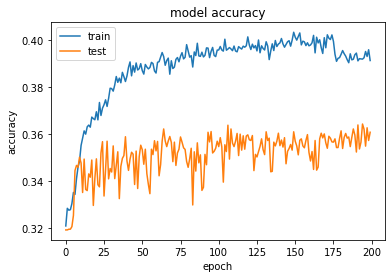

943/943 [==============================] - 2s 2ms/step - loss: 1.9805 - accuracy: 0.3695


In [30]:

modelc = build_classification_model(x_train, y_train)
#預測test
pred_cy = modelc.predict(x_test)
evaluate_cy = modelc.evaluate(x_train, y_train,verbose = 1)

#預測train
pred_train_cy = modelc.predict(x_train)
evaluate_train_cy = modelc.evaluate(x_train, y_train,verbose = 1)


In [31]:
#test 績效
precision = precision_m(y_test, pred_cy)
recall = recall_m(y_test, pred_cy)
f1 = f1_m(y_test, pred_cy)
print(f'test preict: precision:{precision}, recall:{recall}, f1:{f1}')

#train
precision_train = precision_m(y_train, pred_train_cy)
recall_train = recall_m(y_train, pred_train_cy)
f1_train = f1_m(y_train, pred_train_cy)
print(f'train preict: precision:{precision_train}, recall:{recall_train}, f1:{f1_train}')

test preict: precision:0.4145631194114685, recall:0.1134130135178566, f1:0.17810213565826416
train preict: precision:0.42093920707702637, recall:0.12303560972213745, f1:0.19041506946086884


In [32]:
# model = Sequential()
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(class_num, activation='softmax'))


# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=params['optimizer'],
#               metrics=['accuracy',f1_m,precision_m, recall_m])

# history = model.fit(x_train, y_train,
#           batch_size=params['batch_size'],
#           epochs=50,
#           verbose=1,validation_data=(x_test, y_test))

# score = model.evaluate(x_test, y_test, verbose=1)
# loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)
# print(f1_score,precision,recall)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left') 
# plt.show()

In [33]:
# from sklearn.model_selection import GridSearchCV 
# from sklearn.pipeline import Pipeline  
# #SVR調參
    
# pipe_svr = Pipeline([('reg', SVR())])

# grid_param_svr = {
#     'reg__estimator__C' : [10,100,1e3], 
#     'reg__estimator__gamma' : [0.1,0.01,0.001,0.0001,0.00001], 
#     'reg__estimator__epsilon' : [0.001,0.0001,0.01,0.00001] 
# }

# gs_svr = (GridSearchCV(estimator=pipe_svr, 
#                       param_grid=grid_param_svr, 
#                       cv=2,
#                       scoring = 'neg_mean_squared_error',
#                       n_jobs = -1))
# gs_svr = gs_svr.fit(x_train,y_train)
# print(gs_svr.best_estimator_ )

In [34]:
# svr = SVR(gamma='scale',epsilon=0.001, )
# # svr = SVR(kernel='rbf', gamma=scale, epsilon=0.001)
# # RMSE: 10.966594
# # MAPE: 26.509665

# svr.fit(x_train,y_train)

In [35]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
# # 評估指標

# y_test = test_data[14].to_numpy().reshape(len(test_data[14].to_numpy()), 1) # 取得答案
# print(y_test.shape)
# scaler = MinMaxScaler().fit(y_test) # 將答案的值進行正規化

# x_test = np.array(x_test)
# yhat = svr.predict(x_test)
# print(yhat.shape)
# preds = scaler.inverse_transform(yhat.reshape(-1, 1))
# print(preds.shape)

# rmse = np.sqrt(mean_squared_error(y_test, preds))
# print("RMSE: %f" % (rmse))
# mape = np.mean(np.abs((preds - y_test) / y_test)) * 100
# print("MAPE: %f" % (mape))

# # 畫圖
# # plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
# # plt.plot(history.history['loss'], label='loss')
# # plt.plot(history.history['val_loss'], label='val_loss')
# # plt.legend()
# # plt.show()